In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# from google.colab import drive
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import random
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [3]:

df=pd.read_csv("creditcard.csv")

### **DATA PRE PROCESSING**


In [4]:
#Engineering data
df = df.sample(frac=1)
df_fe = df
col = list(df_fe)
sc = StandardScaler()
amount = df['Amount'].values
df['Amount'] = sc.fit_transform(amount.reshape(-1, 1))
df.dropna()
# for col in columns:
#     df_fe = df_fe.fillna({col: df_fe[col].mean()})
x = np.array(df_fe[col])
y = np.array(df['Class'])

In [5]:
smote = SMOTE(sampling_strategy=0.2)
x_resampled_orig, y_resampled_orig = smote.fit_resample(x, y)


### **RANDOM FOREST(FITNESS FUNCTION)**

In [6]:
def get_fitness(features):
    train_size = int(len(x_resampled_orig)*0.3)
    x_resampled_df = pd.DataFrame(x_resampled_orig, columns=['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount','Class'])
    x_resampled_subset = x_resampled_df[features].values
    x_resampled_new =x_resampled_subset
    # x_resampled=np.delete(x_resampled, 29, 1)
    x_test = x_resampled_new[train_size:]
    x_train = x_resampled_new[:train_size]
    y_test = y_resampled_orig[train_size:]
    y_train = y_resampled_orig[:train_size]

    #RF classifier
    rf_clf = RandomForestClassifier(max_depth=3)

    #Train RF classifier
    rf_clf.fit(x_train, y_train)

    # Evaluate the model on testing data
    test_preds = rf_clf.predict(x_test)

    # Step 5: Store the predictions
    preds = test_preds

    # Step 6: Evaluate the predictions using accuracy as the performance metric
    accuracy = accuracy_score(y_test, preds)
    return accuracy

### **GENETIC ALGORITHM**

In [7]:
tcol =np.delete(col, 30)
B = []                      # B is the best feature vector (trackes the best population)
C = []                      # C is list of feature vectors
# Step 4: Generate initial population
np.random.shuffle(tcol)
#population = tcol[:16]

#Encoding
population=""
for i in range(30):
     k = random.randint(0, 1)
     population+= str(k);               #population is a feature vector, all features are randomly assigned 1 or 0, decides whether feature selected or not 

# Step 5: Compute candidate feature vector
for i in range(3):


    # Step 6: Generate fitness value
    #fitness = get_fitness(population)
    features=[]                     # features is a block
    for i in range(30):
        if(population[i]=='1'):
            features.append(col[i])             #if population =1 for that feature, then include that feature in the feature block list
    fitness=get_fitness(features)               #get_fitness called uses random forest


    # Step 7: Check if candidate feature vector is optimal
    if len(B) == 0 or fitness > 0.8:                    #update B and put B in C        
        B = population
        C.append(B)


    #Genetic crossover  --> combine parts of two candidate solution to make a new solution
    # Step 8: Perform k-point crossover
    crossover_point = np.random.randint(1, len(population)-1)           #choose a random crossover point, combine initial part of current population and latter part of B after the crossover point
    population = population[:crossover_point] + B[crossover_point:]


    # Step 9: Perform mutation  --> randomly select a point and flip bit
    mutation_point = np.random.randint(0, len(population)-1)
    if(population[mutation_point]=='1'):
        population = list(population)
        population[mutation_point] = "0"
        population = "".join(population)
    else:
        population = list(population)
        population[mutation_point] = "1"
        population = "".join(population)
    #population[mutation_point] = tcol[np.random.randint(0, len(population)-1)]


    # Re evaluate fitness value after mutation
    for i in range(30):
        if(population[i]=='1'):
            features.append(col[i])
    fitness=get_fitness(features)

C

['101111011001100110011001001111',
 '101111011001100110111001001111',
 '101111001001100110111001001111']

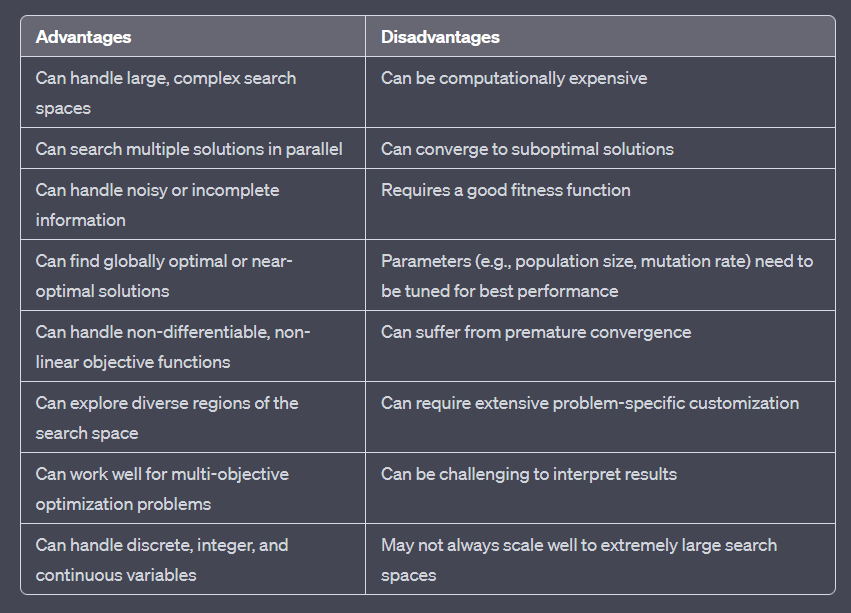

### **HILL CLIMBING**

In [8]:

tcol =np.delete(col, 30)

# make initial feature vector  --> first 10 features are 1, rest are 0
current_features = np.zeros(30, dtype=bool)
for i in range(10):
    current_features[i] = True

# define the neighborhood function to generate neighboring feature vectors

#every time, only one feature is flipped and a new neighbor is formed, so 30 new neighbors made
def neighborhood(current_features):
    neighbors = []
    for i in range(len(current_features)):
        neighbor = np.copy(current_features)
        neighbor[i] = not neighbor[i]
        neighbors.append(neighbor)
    return neighbors

#Mapping encoded features to actual features
# if 
def get_feature(cur_feat):
    features=[]             # features will hold the enabled features' names
    for i in range(30):
        if(cur_feat[i]==1):
            features.append(tcol[i])        #if bit = 1, then corresponding feature name from tcol is appended to features
    return features

# define the hill climbing algorithm

def hill_climbing(current_features, get_fitness, neighborhood, get_feature):
    i=0;
    while i<2:
        # find the best neighbor
        neighbors = neighborhood(current_features)
        best_neighbor = None
        for neighbor in neighbors:
            if best_neighbor is None or get_fitness(get_feature(neighbor)) > get_fitness(get_feature(best_neighbor)):
                best_neighbor = neighbor
                
        # if we went through all neighbors to find the best neighbor, and still the current feature is better than the best neighbor, return the currrent feature
        if get_fitness(get_feature(best_neighbor)) <= get_fitness(get_feature(current_features)):
            return current_features
        
        # if the best neighbor is better than the current feature, then it now becomes our new current feature and we find its neighbors again
        current_features = best_neighbor
        i+=1
        print(get_feature(current_features))    #printing the selected features of the current_features

# run the hill climbing algorithm to select the best features
best_features = hill_climbing(current_features, get_fitness, neighborhood, get_feature)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V17']
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V14', 'V17']


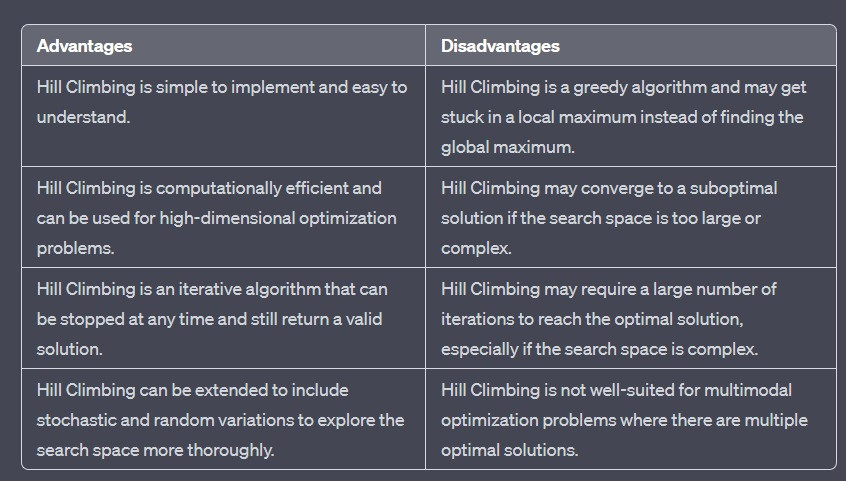

### **PARTICLE SWARM OPTIMIZATION**

In [9]:
# Define the PSO parameters
n_particles = 3
max_iterations = 2
inertia_weight = 0.7    ## previous velocity
cognitive_weight = 1.5  ##distance from particle's best known position
social_weight = 1.5     ## distance from swarm's best known position

# Load the clean Credit Card Fraud dataset
# Assume the dataset is loaded into X and y, where X is the feature matrix and y is the target variable

# Step 1: Generate initial population (feature names)
tcol =np.delete(col, 30)
A = tcol
n_features = 30
particle_position = np.zeros((n_particles, n_features), dtype=bool)
particle_velocity = np.zeros((n_particles, n_features), dtype=bool)
particle_best_position = np.zeros((n_particles, n_features), dtype=bool)
global_best_position = np.zeros(n_features, dtype=bool)
global_best_fitness = float('-inf')

#convert encoded binary features(1010010000111.....) to feature names
def get_feature(cur_feat):
    features=[]
    for i in range(30):
        if(cur_feat[i]==1):
            features.append(tcol[i])
    return features

# Step 2: Initialize particles' positions and velocities
for i in range(n_particles):
    np.random.shuffle(A)
    particle_position[i] = np.random.rand(n_features) < 0.5             #elements in array are randomly given true or false
    particle_velocity[i] = np.random.rand(n_features) < 0.5
    particle_best_position[i] = particle_position[i].copy()

# PSO main loop
for iteration in range(max_iterations):
    
    # Step 3: Compute fitness for each particle
    particle_fitness = np.zeros(n_particles)
    for i in range(n_particles):

        cur_fitness= get_fitness(get_feature(particle_position[i]))     #get features of the particle position, check if the fitness is better than particle fitness and global fitness
        # Update particle's best position and global best position
        
        if cur_fitness > particle_fitness[i]:
            particle_best_position[i] = particle_position[i].copy()
            particle_fitness[i]=cur_fitness
            
        if particle_fitness[i] > global_best_fitness:
            global_best_fitness = particle_fitness[i]
            global_best_position = particle_position[i].copy()

    # Update particles' velocities and positions
    for i in range(n_particles):
        # Update particle's velocity using PSO formula
        particle_velocity[i] = (inertia_weight * particle_velocity[i]
                                + cognitive_weight * np.random.rand(n_features) * (particle_best_position[i] ^particle_position[i])
                                + social_weight * np.random.rand(n_features) * (global_best_position ^particle_position[i]))

        # Update particle's position
        particle_position[i] = particle_position[i] ^ (particle_velocity[i] > 0.5)   #using velocity, we find the next position of the particle

# Extract the selected features from the global best position
selected_features = np.array(A)[global_best_position].tolist()          # A is list of all features,, converted to array, then based on global best position, features are kept, coonvert back to list

# Output the selected features
print("Selected Features:", selected_features)          # selected features are printed back again

Selected Features: ['V22', 'V9', 'V6', 'Time', 'V16', 'V20', 'V11', 'V1', 'V17', 'V7', 'V12', 'V27', 'V18', 'V13', 'V21', 'V10', 'V8']


Simulated Annealing

Find a region with highest density, that becomes our optimum

Amount and class are our x & y values

this tries to predict scams using only amount as a factor and checks how densely the scams are populated

In [10]:


# define the objective function to calculate the density of a given region
def objective_function(region):
    # calculate the area of the region
    area = (region[1][0] - region[0][0]) * (region[1][1] - region[0][1])

    # calculate the number of points inside the region that are TRUE and pairing amount and class together
    num_points = sum((region[0][0] <= x <= region[1][0]) and (region[0][1] <= y <= region[1][1]) for x, y in zip(df['Amount'], df['Class']))

    # calculate the density of the region
    density = num_points / area

    return density

# define the initial temperature, cooling rate, and number of iterations
initial_temperature = 100       #randomness
cooling_rate = 0.003            #reduction in randomness, oncrease in selectivity of better solutions
num_iterations = 1000

# define the search space for the region
min_x = min(df['Amount'])
max_x = max(df['Amount'])
min_y = min(df['Class'])
max_y = max(df['Class'])

# random region is taken as initial solution
current_region = [[np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)],
                  [np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)]]

# define the best solution found so far as the initial solution
best_region = current_region
best_density = objective_function(current_region)


# iterate for the specified number of iterations
for i in range(num_iterations):
    
    
    # create new solution by getting a new random region by randomly disturbing the current region
    new_region = [[np.random.normal(current_region[0][0], 1), np.random.normal(current_region[0][1], 1)],
                  [np.random.normal(current_region[1][0], 1), np.random.normal(current_region[1][1], 1)]]

    # calculate the objective function value for the new solution
    new_density = objective_function(new_region)

    # if new density is lower than best density, then new density is the new solution
    #here, lower density is better as we want to dete4ct anomalies, fraud transactions are lesser and rarer, so they have more chances in lesser dense areas
    if new_density < best_density:
        best_region = new_region
        best_density = new_density

    # calculate the acceptance probability for the new solution
    
    #acceptance probability - allows accepting a worse solution in hopes of exploring further regions with better solutions, (crossing local optima to reach global optima)
    
    delta_density = new_density - best_density
    temperature = initial_temperature * math.exp(-cooling_rate * i)
    acceptance_probability = math.exp(-delta_density / temperature)     ##acceptance probability of new solutions reduces with temperature 

    # if the new solution is worse than the current solution, accept it with a certain probability to reach global optima
    if acceptance_probability > np.random.uniform(0, 1):
        current_region = new_region

# print the best solution found
print("Best region:", best_region)

#(x1,y1), (x2,y2) -- area

Best region: [[72.66762183709619, 0.9225349552312094], [32.938421690136785, 0.0954638754975895]]


Displaying Data

time of transaction vs amount of transaction

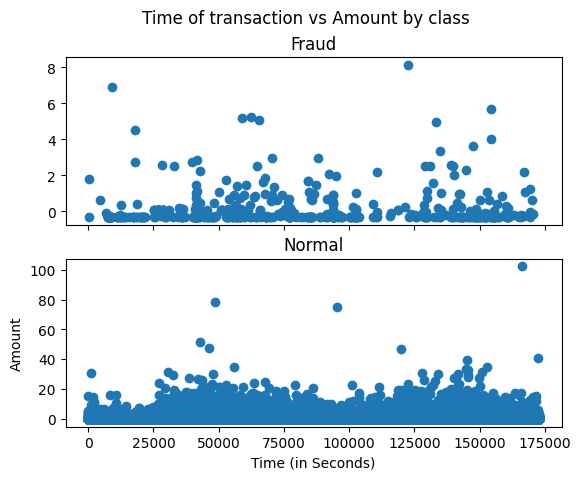

In [11]:
Fraud = df[df['Class']==1]
Normal = df[df['Class']==0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
Fraud.Amount.describe()


count    492.000000
mean       0.135382
std        1.026242
min       -0.353229
25%       -0.349231
50%       -0.316247
75%        0.070128
max        8.146182
Name: Amount, dtype: float64

In [13]:
Normal.Amount.describe()

count    284315.000000
mean         -0.000234
std           0.999942
min          -0.353229
25%          -0.330640
50%          -0.265271
75%          -0.045177
max         102.362243
Name: Amount, dtype: float64

C:\Users\soham\AppData\Local\Temp\ipykernel_10124\1439098623.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

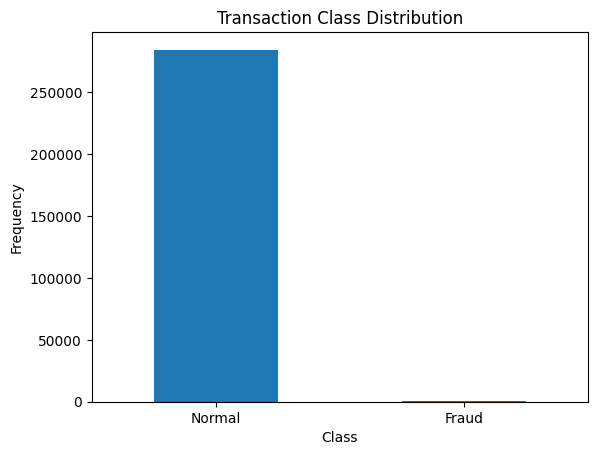

In [14]:
count_classes = pd.value_counts(df['Class'], sort = True)       #count occurence of each class (Normal and Fraud)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")
LABELS = ["Normal","Fraud"]
plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

Determine number of Fraud and Valid Transaction in the data set

In [15]:
data1= df.sample(frac = 0.1,random_state=1)

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))         #ratio of fraud/valid

print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


Correlation plot

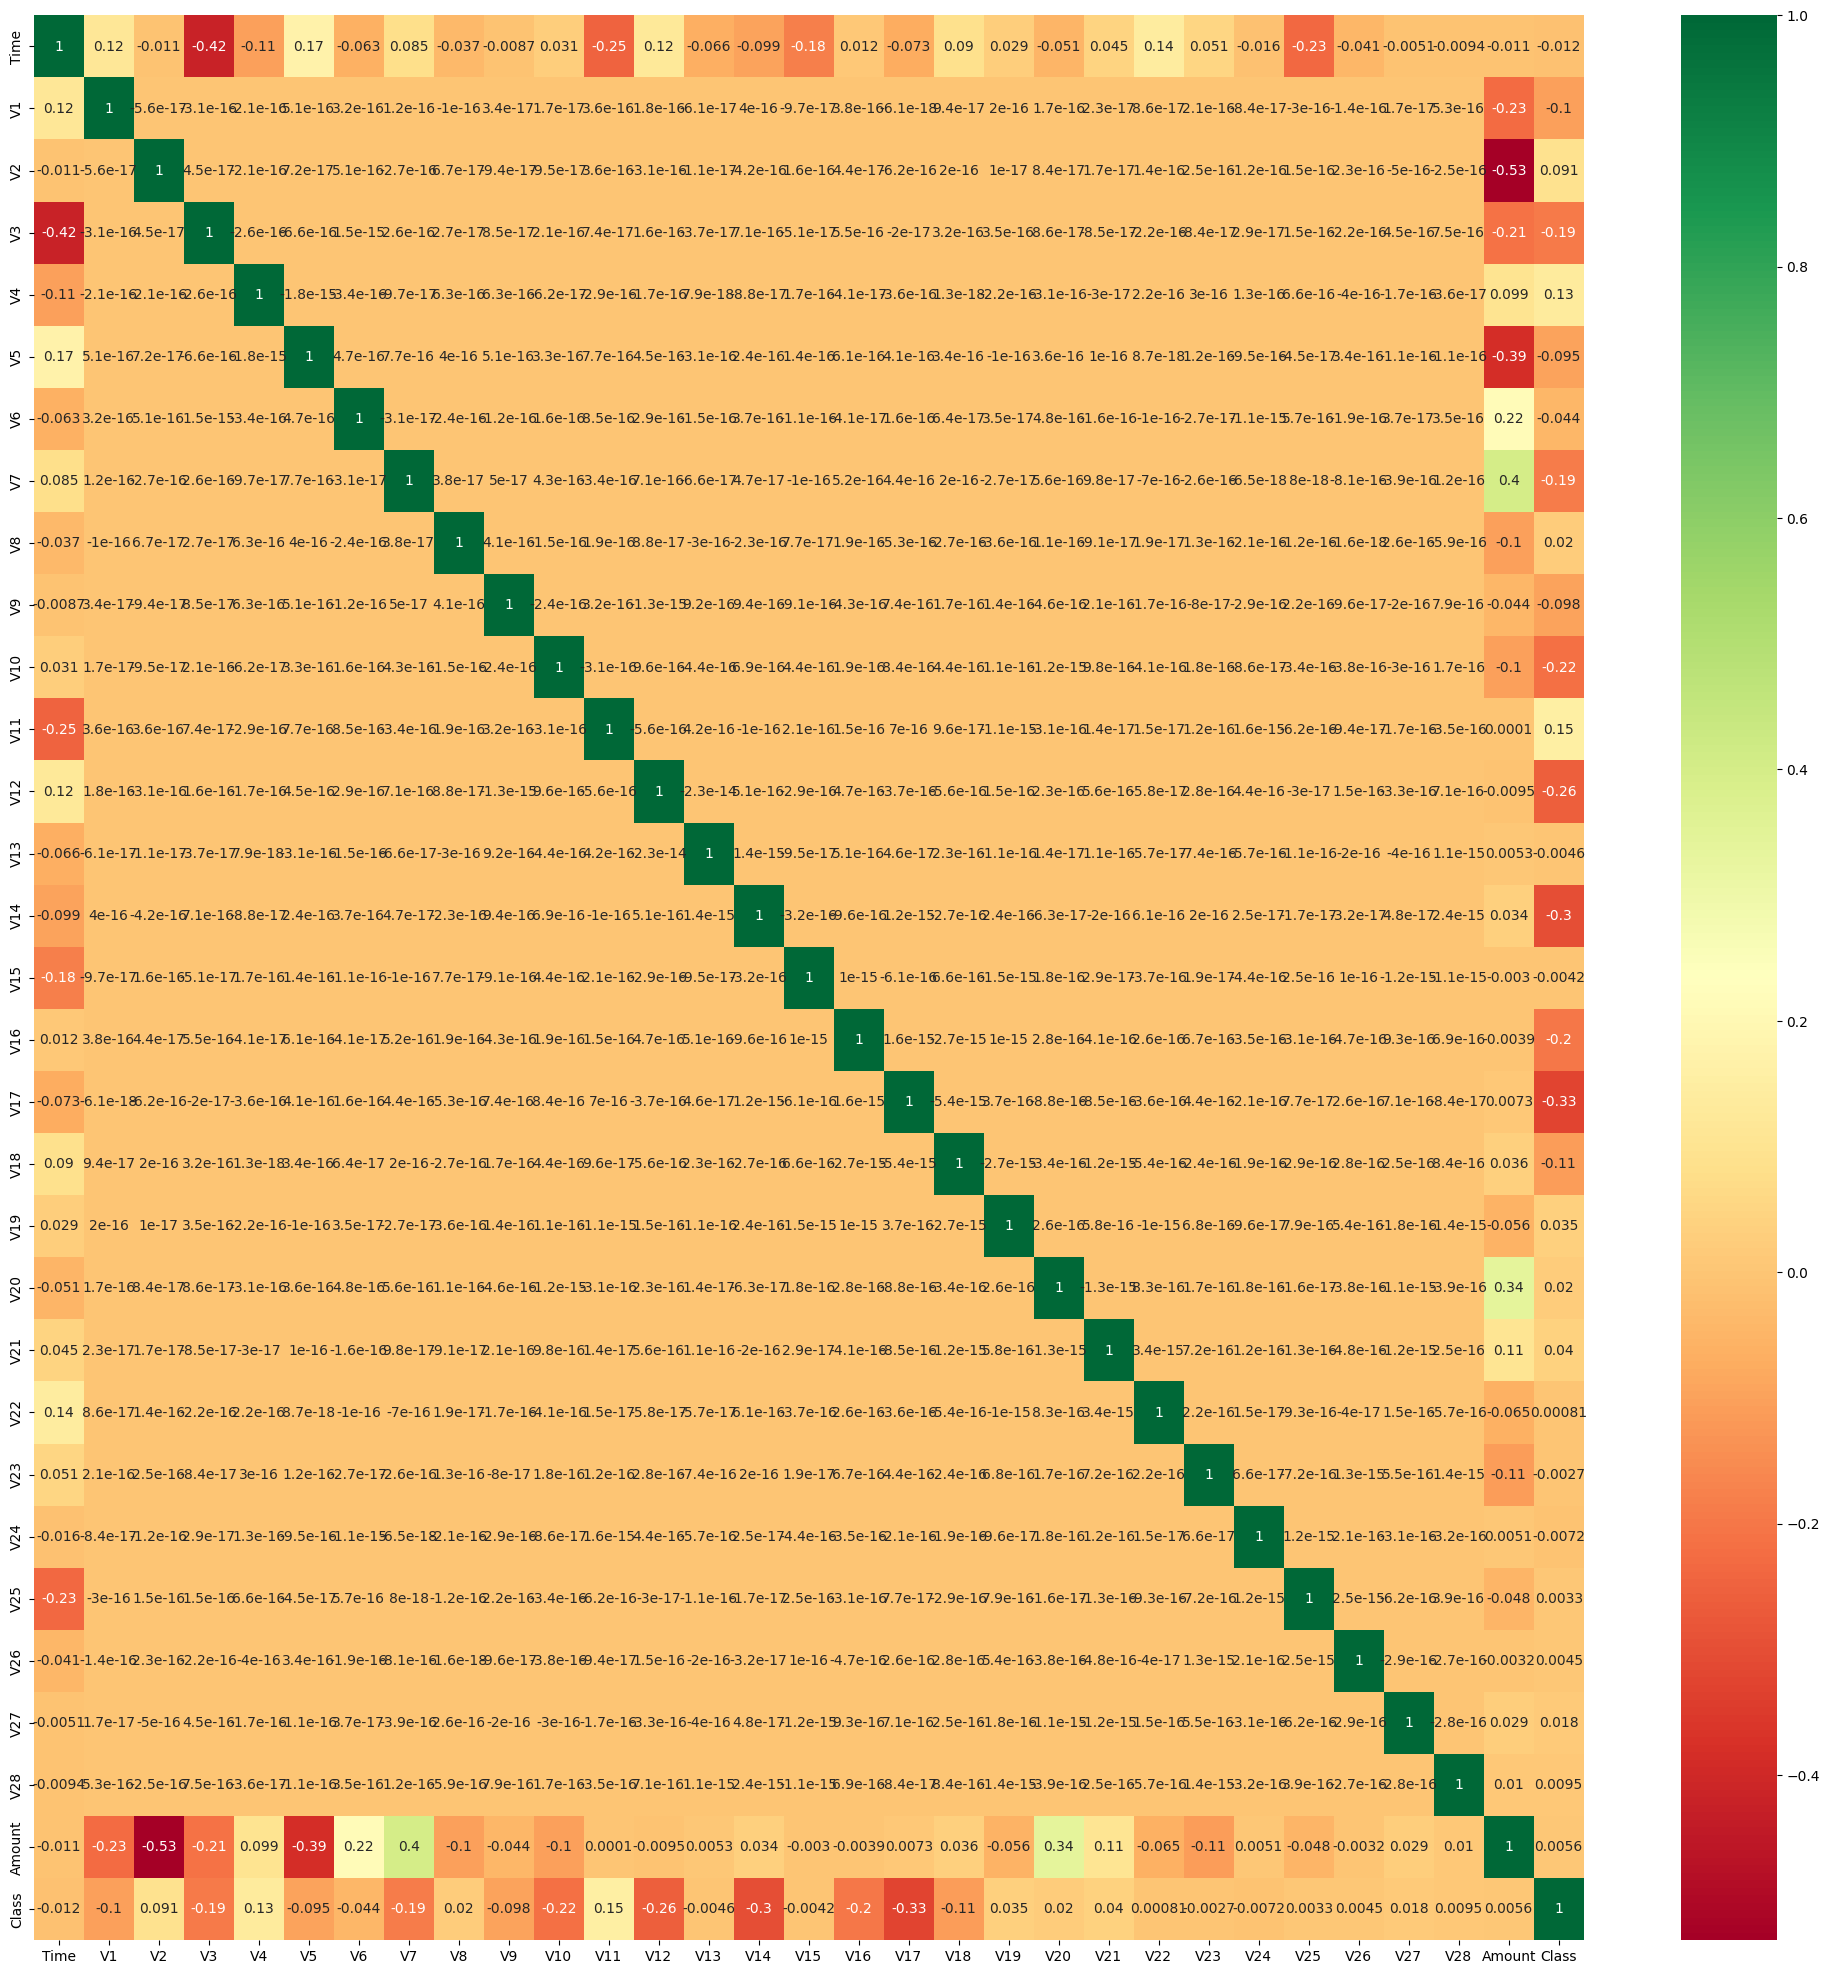

In [17]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

From the above Correlation matrix we can conclude that the parameteres V7 and V20 are highly correlated to the target variable i.e Class. Hence, these may have a higher weight while constructing a decision tree.

Local Outlier Factor :- The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [18]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]            #remove column named class
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))   #X_outliers will be a randomly generated array with the same number of rows and columns as X, each element is from uniform distribution between 0 and 1. could be used for testing or evaluating the performance of outlier detection algorithms.
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


F1 Score and Accuracy generation:-

In [19]:
#Isolation Forest -- at every node of the tree, randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that feature. Anomaly's tree depth would be lower than normal's tree depth as anomalies would split in lesser variables also
#Local Outlier Factor - points with less density around them are outliers - these outliers could be fraud

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)

}

n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_            #degree of outlierness of a point
        
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
        
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)            #distance from hyperplance
        y_pred = clf.predict(X)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 67
Accuracy Score :
0.9976475545100242
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.32      0.33      0.32        49

    accuracy                           1.00     28481
   macro avg       0.66      0.66      0.66     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 95
Accuracy Score :
0.9966644429619747
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.04      0.04      0.04        49

    accuracy                           1.00     28481
   macro avg       0.52      0.52      0.52     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 14422
Accuracy Score :
0.4936273305010358
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.49  

- Isolation Forest detected 71 errors versus Local Outlier Factor detecting 105 errors vs. SVM detecting 14566 errors
- Isolation Forest has a 99.75% more accurate than LOF of 99.63% and SVM of 48.85%
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

Precision and recall are two common metrics used to evaluate the performance of a binary classification model. They are calculated based on the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) as follows:

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Precision is the proportion of true positives among all predicted positives. In other words, it measures how many of the positive predictions made by the model are correct. A high precision means that the model is not making many false positive errors.

Recall is the proportion of true positives among all actual positives. In other words, it measures how many of the positive instances in the data are correctly identified by the model. A high recall means that the model is not missing many positive instances in the data.

Both precision and recall range from 0 to 1, with a higher score indicating better performance.

F1 score is a commonly used metric to evaluate the performance of a binary classification model. It is the harmonic mean of precision and recall, and is defined as:

F1 score = 2 * (precision * recall) / (precision + recall)

The F1 score ranges from 0 to 1, with a higher score indicating better performance. A perfect classifier has an F1 score of 1.0, while a random classifier has an expected F1 score of 0.5 for a balanced dataset.